hackathon source = https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

## Problem Statement
### About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

## Data

**Variable**         |**Description**
:--------------------|:------------------------
Loan_ID              |Unique Loan ID
Gender               |Male/ Female
Married              |Applicant married (Y/N)
Dependents           |Number of dependents
Education            |Applicant Education (Graduate/ Under Graduate)
Self_Employed        |Self employed (Y/N)
ApplicantIncome      |Applicant income
CoapplicantIncome    |Coapplicant income
LoanAmount           |Loan amount in thousands
Loan_Amount_Term     |Term of loan in months
Credit_History       |Credit history meets guidelines
Property_Area        |Urban/ Semi Urban/ Rural
Loan_Status          |Loan approved (Y/N)
 

**Note:**

Evaluation Metric is accuracy i.e. percentage of loan approval you correctly predict.
You are expected to upload the solutionin a csv file with the following format:

Loan_ID | Loan_Status
:------:|:------------:
LP001002|1
LP001003|0
...     |...
LP001010|1

In [48]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import itertools
import csv
import zipfile

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import SMOTE

from scipy import interp
from itertools import cycle

plt.style.use('ggplot')

## Read the data

In [2]:
datadir = './data'

def read_data(folder, extension):
    train = pd.read_csv(os.path.join(folder, 'train{}'.format(extension)))
    test = pd.read_csv(os.path.join(folder, 'test{}'.format(extension)))
    return train, test

train_dataset, test_dataset = read_data(datadir, extension='.csv')

train_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Descriptive analysis

In [3]:
def dataframe_summary(data, vartype='numeric'):
    MAX_VALUES = 10
    
    if vartype == 'numeric':
        include = None
    elif vartype == 'categorical':
        include = ['O']
    
    desc = data.describe(include=include)
    
    if not 'unique' in desc.index:
        desc.loc['unique', :] = data[desc.columns].apply(lambda x: len(x.unique())).values
        
    desc.loc['missing %', :] = (1 - desc.loc['count', :] / len(data)) * 100
    desc.loc['unique %', :] = desc.loc['unique', :] / len(data) * 100

    if vartype == 'categorical':
        for c in desc.columns:
            desc.loc['values', c] = data[c].unique()[:MAX_VALUES]
        
    return desc

tmp = dataframe_summary(train_dataset, vartype='categorical')
discrete_columns = tmp.columns
tmp

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002262,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422
missing %,0,2.11726,0.488599,2.443,0,5.21173,0,0
unique %,100,0.325733,0.325733,0.651466,0.325733,0.325733,0.488599,0.325733
values,"[LP001002, LP001003, LP001005, LP001006, LP001...","[Male, Female, nan]","[No, Yes, nan]","[0, 1, 2, 3+, nan]","[Graduate, Not Graduate]","[No, Yes, nan]","[Urban, Rural, Semiurban]","[Y, N]"


In [4]:
discrete_columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
tmp = dataframe_summary(train_dataset, vartype='numeric')
numeric_columns = tmp.columns
tmp

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.000000,564.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.842199
std,6109.041673,2926.248369,85.587325,65.120410,0.364878
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000
unique,505.000000,287.000000,204.000000,11.000000,3.000000
missing %,0.000000,0.000000,3.583062,2.280130,8.143322


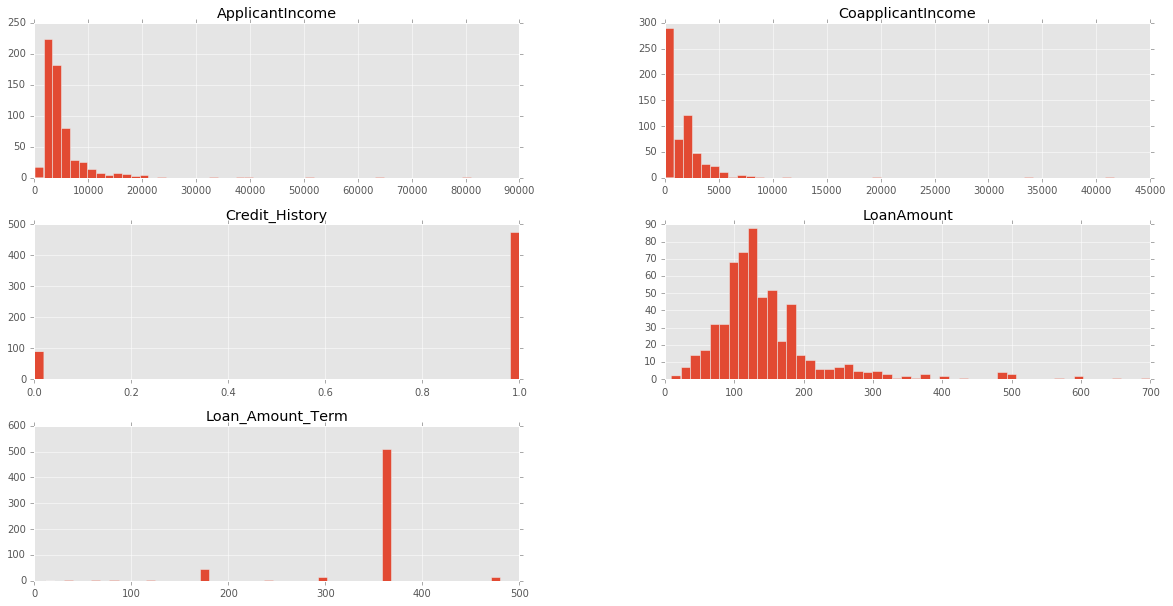

In [6]:
_ = train_dataset.hist(figsize=(20, 10), bins=50)

In [7]:
train_dataset['Loan_Amount_Term'].mode()[0]

360.0

## Preprocess

In [8]:
def vprint(flag, msg):
    if flag:
        print(msg)
           
            
class Encoder():
    def __init__(self, target, subset=None, missing='impute', drop_cols=(), flag_nan=(), verbose=True):
        self.target = target
        self.subset = subset
        self.missing = missing
        self.drop_cols = drop_cols
        self.imputer = Imputer(strategy='mean')
        self.flag_nan = flag_nan
    
    def _process(self, data, verbose=True):
        drop_cols = list(
            tuple(self.drop_cols) + (self.target, ) if self.target in data.columns else self.drop_cols
        )

        labels = None
        
        # Fix Dependents variable
        vprint(verbose, "Fix Dependents variable")
        data['Dependents'] = data['Dependents'].astype(str).str.replace('+', '').astype(float)
        
        # Create Monthly payments
        vprint(verbose, "Create monthly_payments variable")
        data['monthly_payments'] = data['LoanAmount'] / data['Loan_Amount_Term']
        
        # Flag rare values
        vprint(verbose, "Flag rare values in Loan_Amount_Term_rare")
        data["Loan_Amount_Term_rare"] = ~(data['Loan_Amount_Term'] == data['Loan_Amount_Term'].mode()[0])
        
        # One-hot encoding
        vprint(verbose, "One Hot Encoding: {}".format(self.subset))
        df = pd.get_dummies(
            data=data,
            dummy_na=True,
            columns=self.subset
        )
        
        # Missing values
        if self.missing == 'drop':
            vprint(verbose, "Drop missing values")
            df = df.dropna(subset=df.columns.drop(drop_cols))
            
        index = df.index
        
        # Build labels
        if self.target in df.columns:
            vprint(verbose, "Parse target variable: {}".format(self.target))
            # Parse target variable
            df[self.target] = (df[self.target] == "Y").astype(int).values
            labels = df[self.target].values

        # Drop columns
        vprint(verbose, "Drop columns: {}".format(drop_cols))
        X = df[df.columns.drop(drop_cols)].copy()

        # Flag NaN in numeric variables
        vprint(verbose, "Tag NaN for: {}".format(self.flag_nan))
        for c in self.flag_nan:
            X['{}_nan'.format(c)] = X[c].isnull()
            X[c] =X.fillna(0)
            
        # Get features
        vprint(verbose, "Get feature list")
        features = X.columns.tolist()

        vprint(verbose, "Done")
        return X, labels, features, index
        
        
    def fit(self, data):
        X, _, _, _ = self._process(data, verbose=False)
        self.imputer.fit(X.as_matrix())

    def transform(self, data, verbose=False):
        X, labels, features, index = self._process(data, verbose=verbose)

        # Missing values        
        if self.missing == 'impute':
            X = self.imputer.transform(X.as_matrix())
        else:
            X = X.as_matrix()
            
        return X, labels, features, index

    
def predict_with_threshold(X, classifier, threshold):
    return np.apply_along_axis(arr=classifier.predict_proba(X), 
                               axis=1, func1d=lambda x: 1 if x[1] > threshold else 0)

    
encoder = Encoder(
    target='Loan_Status', 
    subset=['Credit_History', 'Married', 'Education', 'Self_Employed', 'Property_Area'], 
    drop_cols=['Loan_ID', 'Gender'],
    flag_nan=['Dependents'],
    missing='impute'
)

encoder.fit(train_dataset)
X, labels, features, index = encoder.transform(train_dataset, verbose=True)
features

Fix Dependents variable
Create monthly_payments variable
Flag rare values in Loan_Amount_Term_rare
One Hot Encoding: ['Credit_History', 'Married', 'Education', 'Self_Employed', 'Property_Area']
Parse target variable: Loan_Status
Drop columns: ['Loan_ID', 'Gender', 'Loan_Status']
Tag NaN for: ['Dependents']
Get feature list
Done


['Dependents',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'monthly_payments',
 'Loan_Amount_Term_rare',
 'Credit_History_0.0',
 'Credit_History_1.0',
 'Credit_History_nan',
 'Married_No',
 'Married_Yes',
 'Married_nan',
 'Education_Graduate',
 'Education_Not Graduate',
 'Education_nan',
 'Self_Employed_No',
 'Self_Employed_Yes',
 'Self_Employed_nan',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Property_Area_Urban',
 'Property_Area_nan',
 'Dependents_nan']

### Shuffle and split training and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=.3, random_state=0)

### Handle unbalanced classes

For this we will use the SMOTE algorithm (Synthetic Minority Over-sampling Technique) after spliting the dataset in training and test.

In [10]:
smote = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = smote.fit_sample(X_train, y_train)

print('Before upscaling: {} --> After upscaling: {}'.format(
    np.bincount(y_train), np.bincount(y_train_res))
)

Before upscaling: [141 288] --> After upscaling: [288 288]


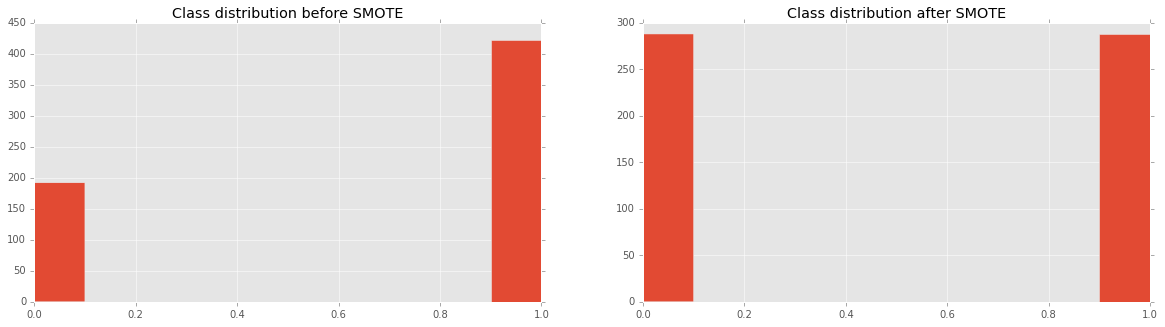

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

a = (train_dataset['Loan_Status'] == "Y").astype(int).hist(ax=axes[0])
a.set_title('Class distribution before SMOTE')
a = pd.Series(y_train_res).hist(ax=axes[1])
a.set_title('Class distribution after SMOTE')
del a

### Models

In [56]:
def compute_accuracy(X, y, classifier):
    return accuracy_score(
        y.astype(float), 
        np.apply_along_axis(arr=classifier.predict_proba(X), axis=1, func1d=np.argmax)
    )


def plot_roc(y_true, y_score):
    lw = 2
    n_classes = labels.shape[1] if len(labels.shape) > 1 else 1
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,5))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        thresh = 0.6
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.

#     print(cm)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def build_classifier(model_class, X_train, y_train, X_test, y_test, **kwargs):
    # Define model
    clf = model_class(**kwargs)
    clf.fit(X_train, y_train)
    print('Train accuracy', compute_accuracy(X_train, y_train, classifier=clf))
    print('Test accuracy', compute_accuracy(X_test, y_test, classifier=clf))
    return clf


def build_models(*args, X_train, y_train, X_test, y_test):
    results = []
    for idx, val in enumerate(args):
        clf, params = val
        print("######## Model {} out of {}: {}".format(idx, len(args), clf.__name__))
        results.append(build_classifier(clf, X_train, y_train, X_test, y_test, **params))
    return results

### Baseline performance

Compute the accuracy if all the predicted values where the most common class (0, 'NO')

In [53]:
print('Train accuracy: ', accuracy_score(y_train, np.zeros(len(y_train))))
print('Trest accuracy: ', accuracy_score(y_test, np.zeros(len(y_test))))

Train accuracy:  0.328671328671
Trest accuracy:  0.275675675676


### Train and evaluate models

In [57]:
params_gbm = {
    "loss": 'deviance', 
    "learning_rate": 0.1, 
    "n_estimators": 100,
    "subsample": 1.0, 
    "criterion": 'friedman_mse', 
    "min_samples_split": 2,
    "min_samples_leaf": 1, 
    "min_weight_fraction_leaf": 0.0,
    "max_depth": 3, 
    "min_impurity_split": 1e-07,
    "random_state": 10, 
    "max_features": None, 
    "verbose": 0, 
    "max_leaf_nodes": None
}


params_rf = {
    "n_estimators": 500,
    "criterion": 'entropy',
    "max_depth": 5,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": 'auto',
    "max_leaf_nodes": None,
    "bootstrap": True,
    "n_jobs": 2,
    "random_state": 5,
    "verbose": 0,
    "warm_start": False,
}



**Accuracy for training data**

In [58]:
models = build_models(
    (GradientBoostingClassifier, params_gbm),
    (RandomForestClassifier, params_rf),
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

######## Model 0 out of 2: GradientBoostingClassifier
Train accuracy 0.902097902098
Test accuracy 0.810810810811
######## Model 1 out of 2: RandomForestClassifier
Train accuracy 0.81351981352
Test accuracy 0.827027027027


**Accuracy for training data with SMOTE**

In [59]:
models_res = build_models(
    (GradientBoostingClassifier, params_gbm),
    (RandomForestClassifier, params_rf),
    X_train=X_train_res, y_train=y_train_res, X_test=X_test, y_test=y_test
)

######## Model 0 out of 2: GradientBoostingClassifier
Train accuracy 0.9375
Test accuracy 0.794594594595
######## Model 1 out of 2: RandomForestClassifier
Train accuracy 0.852430555556
Test accuracy 0.832432432432


In [61]:
USE_CLASSIFIER = models_res[1]
THRESHOLD = 0.5

ROC Train


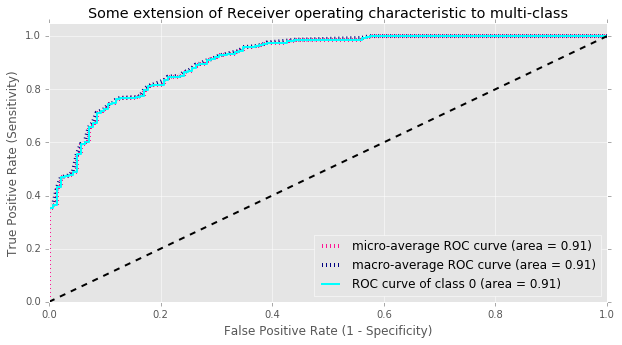


ROC Test


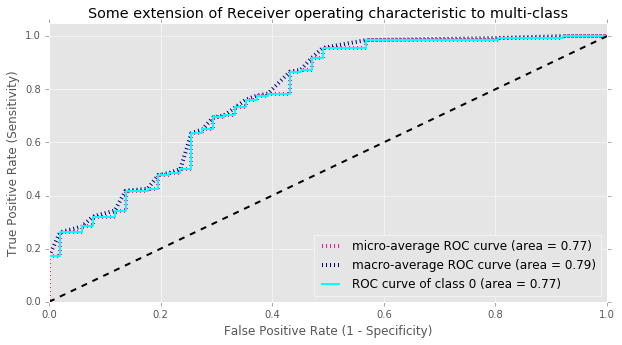

Confusion matrix, without normalization
Normalized confusion matrix


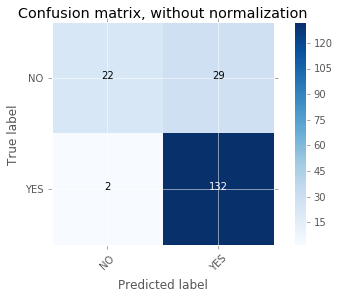

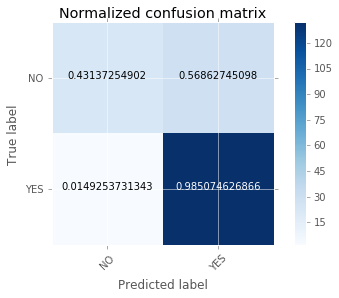

Feature ranking:


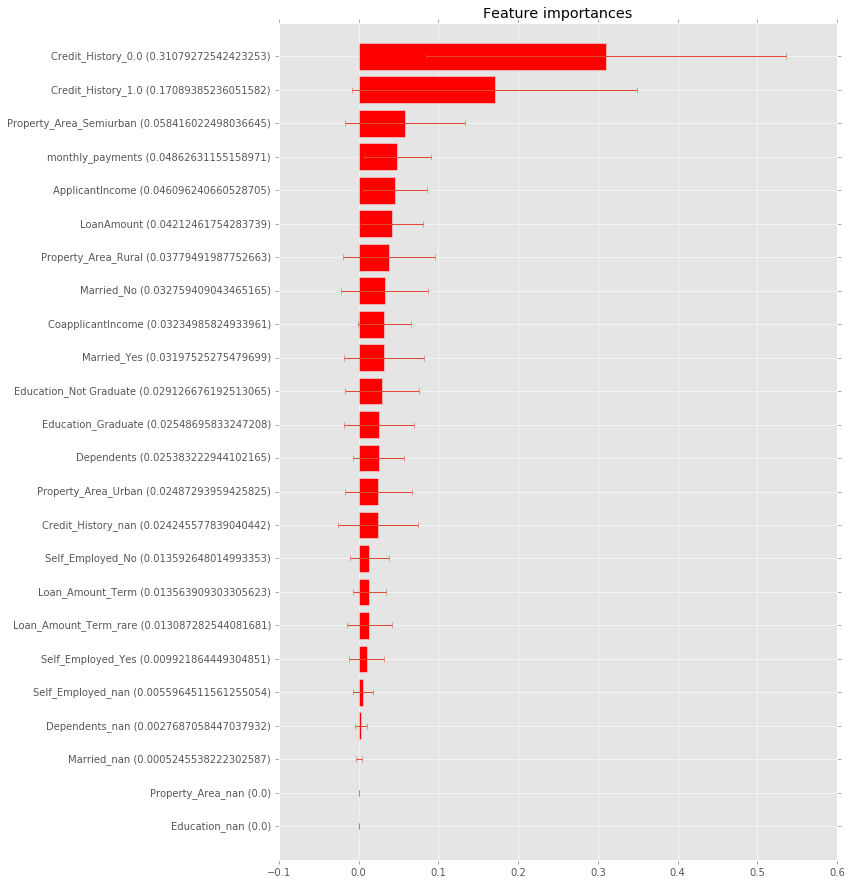

Prediction distribution


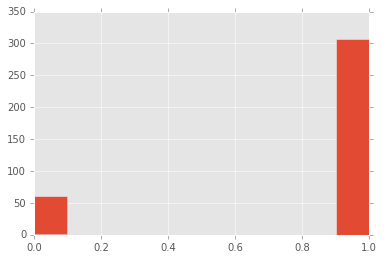

In [62]:
def get_importances(clf, names=None, plot=False):
    importances = clf.feature_importances_
    
    if isinstance(clf, RandomForestClassifier):
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    elif isinstance(clf, GradientBoostingClassifier):
        std = np.std([tree[0].feature_importances_ for tree in clf.estimators_], axis=0)
    
    indices = np.argsort(importances)[::-1]
    features = ["feature {}".format(i) for i in indices] if names is None else names
    
    if plot:
        # Print the feature ranking
        print("Feature ranking:")

        # Plot the feature importances of the forest
        plt.figure(figsize=(10,15))
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices], color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), ["{} ({})".format(features[i], importances[i]) for i in indices], rotation=0)
        plt.ylim([-1, X.shape[1]])
        plt.gca().invert_yaxis()
        plt.show()
    
    return importances, indices


def build_solution_dataframe(data, classifier, threshold=0.5):
    X, _, _, index = encoder.transform(data)
    
    res = pd.DataFrame({
        'Loan_ID': data.loc[index, 'Loan_ID'],
        'Loan_Status': predict_with_threshold(X, classifier, threshold)
    })
    _ = res['Loan_Status'].hist()
    return res.replace({1: 'Y', 0: "N"})


def report(clf, threshold=0.5):
    #### ROC curves
    print("ROC Train")
    plot_roc(y_train, clf.predict_proba(X_train)[:,1])
    print("")
    print("ROC Test")
    plot_roc(y_test, clf.predict_log_proba(X_test)[:,1])
    
    class_names = ['NO', 'YES']

    ### Confusion matrix
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, predict_with_threshold(X_test, clf, threshold))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ### Feature importance
    importances, idx = get_importances(clf, names=features, plot=True)

    ### Output dataframe
    print("Prediction distribution")
    solution_df = build_solution_dataframe(test_dataset, classifier=clf, threshold=threshold)
    solution_df.head()
    
    return solution_df, importances

solution_df, importances = report(clf=USE_CLASSIFIER, threshold=THRESHOLD)

In [63]:
def build_solution_file(filename, dataframe, tag=''):
    solution_df.to_csv(filename, index=False, quoting=csv.QUOTE_ALL)
    zipf = zipfile.ZipFile('submission_{}.zip'.format(tag), 'w', zipfile.ZIP_DEFLATED)
    zipf.write(filename)
    zipf.close()
    
timetag = format(pd.Timestamp.utcnow().tz_convert('Europe/Paris'), '%Y%m%d%H%M%S')
filename = "./result_{}.csv".format(timetag)

build_solution_file(filename, solution_df, tag=timetag)

score = 0.784722